In [1]:
import pandas as pd 
import numpy as np
import os 
import json
from math import ceil, floor

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest,chi2

from sklearn.preprocessing import LabelEncoder,scale
from sklearn.feature_extraction.text import TfidfVectorizer  
from sklearn.naive_bayes import ComplementNB
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.utils.multiclass import unique_labels

from sklearn.pipeline import Pipeline
from sklearn.externals import joblib

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 11})

import re
import nltk
from nltk.corpus import stopwords


from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Activation, Conv1D, Dense, Embedding, Flatten, Input, Dropout, GlobalMaxPooling1D
from keras.metrics import categorical_accuracy
from keras.callbacks import  EarlyStopping


Using TensorFlow backend.


In [2]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;-]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))
Number_RE = re.compile('[*^0-9]')
Bad_underline = re.compile('[*_*]')
RemoveTag = re.compile('&lt;|br&gt;|b&gt;|ul&gt;|li&gt;')

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = RemoveTag.sub('',text)
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = Number_RE.sub(' ', text) # replace Number symbols by space in text
    text = Bad_underline.sub(' ', text) # replace Underline symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwors from text
    return text
RemoveLastSpace = re.compile(' $')

def clean_text_category(text):
    text = RemoveLastSpace.sub('',text)
    return text
    

In [3]:
def classNumberThreshold(arr):
    dropCategory = []

    for key,value in arr.items():
        if(value<=30):
            dropCategory.append(key)
    return dropCategory

In [4]:
df = pd.read_csv('../../example/amazon_co-ecommerce_sample.csv')

In [5]:
df = df[pd.notnull(df['amazon_category_and_sub_category'])]
df = df[pd.notnull(df['description'])]
df = df[pd.notnull(df['uniq_id'])]
category = []
subcategory = []
sub2category = []
for ele in df['amazon_category_and_sub_category'].apply(lambda x: str(x).split('>')):
    category.append(ele[0])
    if(len(ele)>2):
        subcategory.append(ele[1])
        sub2category.append(ele[2])
    elif(len(ele)>1):
        subcategory.append(ele[1])
        sub2category.append(np.NaN)
    else:
        subcategory.append(np.NaN)
        sub2category.append(np.NaN)

data= {'uniq_id':df['uniq_id'], 'product_name':df['product_name'],'category_main':category,'category_sub1':subcategory,'description':df['description']}
df = pd.DataFrame(data)
df['description'] = df['description'].apply(clean_text)
df.category_main = df['category_main'].apply(clean_text_category)
df.category_sub1 = df['category_sub1'].apply(clean_text_category)

df = df[pd.notnull(df['category_main'])]
df = df[pd.notnull(df['category_sub1'])]


In [6]:
dropCategoryCode  = classNumberThreshold(df.category_main.value_counts())
dropSubCategoryCode  = classNumberThreshold(df.category_sub1.value_counts())

for i in dropCategoryCode:
    df = df[df.category_main!=i]
    
for i in dropSubCategoryCode:
    df = df[df.category_sub1!=i]



In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8189 entries, 0 to 9998
Data columns (total 5 columns):
uniq_id          8189 non-null object
product_name     8189 non-null object
category_main    8189 non-null object
category_sub1    8189 non-null object
description      8189 non-null object
dtypes: object(5)
memory usage: 383.9+ KB


In [8]:
le = LabelEncoder()
le.fit(df.category_main)
target = le.classes_
labels = le.transform(df.category_main)

le.fit(df.category_sub1.apply(str))
subtarget = le.classes_
sublabels = le.transform(df['category_sub1'])

In [9]:
tfidfconverter = TfidfVectorizer(min_df=5, max_df=0.7)
X = tfidfconverter.fit_transform(df.description)
featureNames = tfidfconverter.get_feature_names()

In [10]:
X_train, X_test, y_train_info, y_test_info = train_test_split(X, pd.DataFrame({'index':df.index, 'label':labels}), 
                                                    test_size=0.1, random_state = 27)

In [11]:
y_train = y_train_info.label
y_test = y_test_info.label


In [12]:
model = ComplementNB()
model.fit(X_train,y_train)

ComplementNB(alpha=1.0, class_prior=None, fit_prior=True, norm=False)

In [13]:

classWithInfluence = {}

coef = model.coef_
coef = scale(coef)

coefTotalSize = coef.shape[0]*coef.shape[1]
coef1DArr = coef.reshape(coefTotalSize,1)
Max = ceil(max(coef1DArr[0]))
Min = floor(min(coef1DArr[0]))

for index in range(0,len(coef)):
    normalisedCoef = [round((ele-Min)/(Max-Min),2) for ele in coef[index]]
    name = featureNames
    classWithInfluence[target[index]] = list(zip(name,normalisedCoef))
            
Top10InflunceFeature = {}
for key, value in classWithInfluence.items():
    Top10InflunceFeature[key] = sorted(value, key=lambda x: x[1], reverse=True)[:10]

with open('Amazon/CompanyTopFeatureByClassNBC.json', 'w') as json_file:
    json.dump(Top10InflunceFeature, json_file, indent=2)    

In [14]:
BestSize  = [ele for ele in range(100, len(featureNames), 100) ]
Models = []
Scores = []
SelectModels  = []
for ele in range(100, len(featureNames), 100):
    print("--- Best "+ str(ele) + " features \n")
    selectBest = SelectKBest(chi2, k= ele)
    model = ComplementNB()
    K_best_NBC = Pipeline([('SelectBest', selectBest), ('CNBC', model)])
    K_best_NBC.fit(X_train,y_train)
    score = K_best_NBC.score(X_test,y_test)
    Models.append(K_best_NBC)
    Scores.append(score)

bestModel = Models[np.argmax(Scores)]
bestSize = BestSize[np.argmax(Scores)]

# save the model to disk
filename = 'Amazon/'+str(bestSize)+'BestNBC.sav'
joblib.dump(bestModel, filename)



yConfidence = bestModel.predict_proba(X_test)

yPred = bestModel.predict(X_test)


--- Best 100 features 

--- Best 200 features 

--- Best 300 features 

--- Best 400 features 

--- Best 500 features 

--- Best 600 features 

--- Best 700 features 

--- Best 800 features 

--- Best 900 features 

--- Best 1000 features 

--- Best 1100 features 

--- Best 1200 features 

--- Best 1300 features 

--- Best 1400 features 

--- Best 1500 features 

--- Best 1600 features 

--- Best 1700 features 

--- Best 1800 features 

--- Best 1900 features 

--- Best 2000 features 

--- Best 2100 features 

--- Best 2200 features 

--- Best 2300 features 

--- Best 2400 features 

--- Best 2500 features 

--- Best 2600 features 

--- Best 2700 features 

--- Best 2800 features 

--- Best 2900 features 

--- Best 3000 features 

--- Best 3100 features 

--- Best 3200 features 

--- Best 3300 features 

--- Best 3400 features 

--- Best 3500 features 

--- Best 3600 features 

--- Best 3700 features 

--- Best 3800 features 

--- Best 3900 features 

--- Best 4000 features 

--- Best 

In [15]:
totalConfidenceSize = yConfidence.shape[0]*yConfidence.shape[1]
Confidence1DArr = yConfidence.reshape(totalConfidenceSize,1)
Max = ceil(max(Confidence1DArr)[0])
Min = floor(min(Confidence1DArr)[0])
NormalisedConfid = [round((max(ele)-Min)/(Max-Min),2) for ele in yConfidence]
productID = [ df[df.index==ele]['uniq_id'].values[0] for ele in y_test_info['index'] ]
ProductDescription =[ df[df.index==ele]['description'].values[0] for ele in y_test_info['index'] ]
NBCResult = pd.DataFrame({'id':productID,'description':ProductDescription,
                         'trueClass': y_test,'trueClassNaem':target[y_test] ,
                         'predictClass':yPred,'predictClassName':target[yPred],
                         'Confidence':NormalisedConfid})
NBCResult.to_csv("Amazon/NBCResults.csv",index=False,compression=None)

In [16]:
def draw_confidenceReport(data):
    num = [ ele*0.01 for ele in range(20,81,2)]
    totalitems = []
    correct = []
    incorrect = []
    for ele in num:
        Threshold = data[data['Confidence']>ele]
        correct.append(len(Threshold[Threshold['trueClass']==Threshold['predictClass']].index))
        incorrect.append(len(Threshold[Threshold['trueClass']!=Threshold['predictClass']].index))
        totalitems.append(len(Threshold.index))
    
    ClassfiedProportion = [ ele/len(data.index) for ele in totalitems]
    
    Acc =[]
    for ele in zip(correct,totalitems):
        if (ele[1]==0):
            Acc.append(0)
        else:
            Acc.append(ele[0]/ele[1])

    fig,ax  = plt.subplots()
    
    color = 'tab:blue'
    ax.scatter(num,ClassfiedProportion,label="Proportion classified",color=color)
    ax.set_xlabel("Confidence Score")
    ax.set_ylabel("Proportion classified", color=color)
    ax.xaxis.set_ticks(np.arange(0,1.1,0.1))
    ax.yaxis.set_ticks(np.arange(0,1.1,0.1))
    ax.tick_params(axis='y', labelcolor=color)

    color = 'tab:red'

    ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis

    ax2.scatter(num,Acc,label="Accuracy", color=color)
    ax2.set_ylabel("Accuracy", color=color)
    ax2.yaxis.set_ticks(np.arange(0,1.1,0.1))
    ax2.tick_params(axis='y', labelcolor=color)

    ax.grid()
    fig.savefig("Amazon/ConfidenceScoreReportNBC.png")

In [17]:
print(classification_report(y_test, yPred,target_names=target))
with open('Amazon/NBCReport.txt', 'w') as file:
    file.write(classification_report(y_test, yPred,target_names=target))

                           precision    recall  f1-score   support

            Arts & Crafts       0.77      0.97      0.86        61
      Baby & Toddler Toys       0.00      0.00      0.00         4
      Characters & Brands       0.78      0.57      0.66        83
  Die-Cast & Toy Vehicles       0.79      0.90      0.84       108
      Dolls & Accessories       0.87      0.92      0.89        37
              Fancy Dress       0.93      0.95      0.94        56
       Figures & Playsets       0.78      0.80      0.79       106
                    Games       0.91      0.86      0.88        93
                  Hobbies       0.84      0.74      0.79       148
        Jigsaws & Puzzles       0.70      0.89      0.78        18
           Party Supplies       0.80      0.88      0.84        50
             Pretend Play       1.00      0.40      0.57         5
Puppets & Puppet Theatres       0.79      1.00      0.88        22
    Sports Toys & Outdoor       0.81      0.79      0.80     

/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


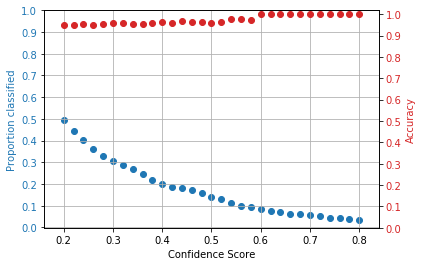

In [18]:
draw_confidenceReport(NBCResult)

In [19]:
cm = confusion_matrix(y_test, yPred)

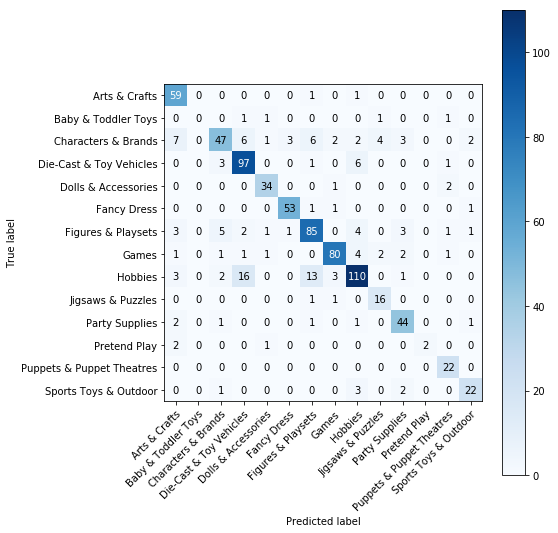

In [20]:
fig, ax = plt.subplots(figsize=(8,8))
im =ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
classes = target[unique_labels(y_test, yPred)]
# We want to show all ticks...
ax.set(xticks=np.arange(cm.shape[1]),yticks=np.arange(cm.shape[0]),
       # ... and label them with the respective list entries
        xticklabels=classes, yticklabels=classes,ylabel='True label',xlabel='Predicted label')
# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
fmt = 'd'
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], fmt),ha="center", va="center", color="white" if cm[i, j] > thresh else "black")
fig.tight_layout()
fig.savefig("Amazon/NBCConfusionMatrix.png")

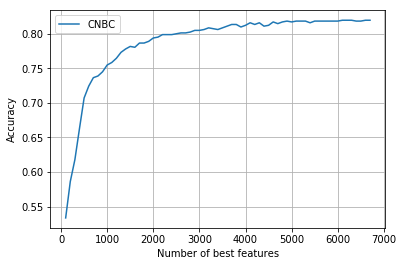

In [21]:
fig,ax  = plt.subplots()
ax.plot(BestSize,Scores,label="CNBC")
ax.set_xlabel("Number of best features")
ax.set_ylabel("Accuracy")
ax.legend()
ax.grid()
fig.savefig("Amazon/CNBCbestFeatureSize.png")